In [1]:
import numpy as np
import pandas as pd
import random
from random import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

from collections import deque

In [2]:
#unique한 job types의 모임
types = ['6633', '6024', '1062', '6310', '6128', '6287', '1075', '1076',
       '6756', '6757', '1101', '6494', '6662', '6705', '6549', '6552',
       '6527', '6531', '1099', '1104', '6754', '6575', '6706', '6589',
       '6232', '6752', '6574', '6053', 'P828', '6692', '6721', '6663',
       '6734', '6681', '6682', '6561', '6750', '6728', '6648', '6584',
       '6102', '6630', '6406', '6407', '1106', '1107', '6542', '6723',
       '6356', '6700', '6572', '6573', '6218', '1017', 'P130', '6763',
       '6650', '6653', '6454', '6452', '6696', '8L39', '8L72', '6698',
       '6433', '6629', '6760', '6380', 'P099', '6585', '6581', '6447',
       '6689', '6761', '6040', '6515', '6217', '6747', '6769', '6738',
       '6751', '6112', '6753', '6301', '6271', '6432', '6675', '6470',
       '6647', '1018', '6238', '6324', '6733', '6206', 'P163', '6719',
       '6205', '6660', '6453', '6655', '6646', '6244', '6695', '6539',
       '6736', '6683', '6634', '6475', 'P147', '6642', '6684', '6477',
       '6608', '6708', 'P837', 'P820', 'P835', '8K52']
machine = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
machine_state = [[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]]


In [3]:
#해당머신마더 존재하는 constraint마다 dataframe형태로 저장

new_table = pd.read_csv("C:\\Users\\wg999\\OneDrive\\바탕 화면\\data_const.csv") #경로지정필요

new_table01 = new_table.groupby('machine').agg(lambda x: ','.join(set(x)))
new_table01 = new_table01.reset_index()
new_table01 = new_table01.reset_index()
del new_table01['machine']
new_table01.columns = ['machine','type']
new_table01
for i in range(0,16):
    new_table01['type'][i] = new_table01['type'][i].split(',') 
new_table01

<ipython-input-3-abed7b9fcca5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_table01['type'][i] = new_table01['type'][i].split(',')


,machine,type
0,0,"[6589, 6754, 6406, 6453, 6719, 6684, 8K52, 620..."
1,1,"[6217, 6754, 6406, 6453, 6692, 6719, 8K52, 620..."
2,2,"[6589, 6754, 6406, 6453, 6684, 8L39, 6205, 645..."
3,3,"[6515, 6271, 6769, 1062, P828, 6102, 6736, 630..."
4,4,"[6217, 6754, 6406, 6453, 6692, 6719, 8K52, 620..."
5,5,"[6629, 6432, 6752, 1075, 6754, 6585, 6757, 666..."
6,6,"[6589, 6754, 6406, 6453, 6684, 8L39, 6205, 645..."
7,7,"[6589, 6754, 6406, 6453, 6719, 6684, 8K52, 620..."
8,8,"[6217, 6754, 6406, 6453, 6692, 6719, 8K52, 620..."
9,9,"[6515, 6271, 6769, 1062, P828, 6575, 6102, 673..."


In [4]:
#epoch마다 loss값 계산을 위한 CustomHistory class
import keras

class CustomHistory(keras.callbacks.Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [5]:
#DQN class
import random

custom_hist = CustomHistory()
custom_hist.__init__()


class DQN:
    def __init__(self):
        self.memory = deque(maxlen=2000)
        
        #hyper parameters 바꿔보면서 실험
        self.gamma = 0.85 
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.tau = .125
        
        #Q-Network , target Q-Network create
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_train()
        
    #전체적인layer구성 
    def create_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=32, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(16, activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate)) #optimizer Adam
        
        return model
    
    #Q-Network or random 으로 action 추출
    def act(self, state):
        #act가 선언될때마다 epsilon에 epsilon_decay를 곱해 랜덤으로 action을 고를 확률을 낮춰준다
        self.epsilon *= (self.epsilon_decay) 
        self.epsilon = max(self.epsilon_min, self.epsilon)
        #epsilon값과 비교할 random_value 생성
        random_val = np.random.random()
        
        if random_val < self.epsilon:
            #random_value가 epsilon값 보다 작은경우 action을 random하게 고른다
            blank = []
            for i in range(len(new_table01['type'])):
                for j in range(len(new_table01['type'][i])):
                    if new_table01['type'][i][j] == current_type:
                        blank.append(i)
            return random.choice(blank)
        else:
            #random_value가 epsilon값 보다 클경우 action을 Q-Network에 넣어줘서 action값을 얻는다.
            blank = []
            for i in range(len(new_table01['type'])):
                for j in range(len(new_table01['type'][i])):
                    if new_table01['type'][i][j] == current_type:
                        blank.append(i)
            score = self.model.predict(state)
            
            blank2 = []
            for i in blank:
                ax = score[0][i]
                blank2.append(ax)
            max_q_val = max(blank2)
            
            index_of_max = np.where(score[0] == max_q_val)
            iom = index_of_max[0][0]
            
            return iom
    
    #memory에 (state, action, reward, next_state, done)sample저장
    #memory는 크기가 2000인 deque 자료구조로써 2000만큼 채워지면 앞서채워진것부터 순차적으로 지워지면서 다시 채워진다.
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
        
    #memory에서 batch size 만큼 샘플추출해서 training 진행
    def replay(self):
        batch_size = 200
        if len(self.memory) < batch_size:
            return
        
        samples = random.sample(self.memory, batch_size)
        X = []
        Y = []
        for sample in samples:
            state, action, reward, next_state, done = sample
#             print(reward)
            target = self.target_model.predict(state)
#             print(target)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(next_state)[0])
#                 print(Q_future)
                target[0][action] = reward + Q_future * self.gamma
#                 print(target[0][action])
            
            X.append(state)
            Y.append(target)
        X = np.array(X)
        Y = np.array(Y)
        self.model.fit(X, Y, epochs=1,batch_size = 200, verbose=0, callbacks=[custom_hist])

    #Q-Network 가중치를 target Q-Network로 그대로 옮기는 과정
    #한번의 epoch(replay) 가 돌때마다 target_model의 weights를 수정해준다.
    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i]* self.tau + target_weights[i]*(1-self.tau)
        self.target_model.set_weights(target_weights)


        
    #완성된 모델 save
    def save_model(self, fn):
        self.model.save(fn)



In [7]:
dqn_agent = DQN()

for k in range(500):

#     dqn_agent.memory_clear()
    types = ['6633', '6024', '1062', '6310', '6128', '6287', '1075', '1076',
       '6756', '6757', '1101', '6494', '6662', '6705', '6549', '6552',
       '6527', '6531', '1099', '1104', '6754', '6575', '6706', '6589',
       '6232', '6752', '6574', '6053', 'P828', '6692', '6721', '6663',
       '6734', '6681', '6682', '6561', '6750', '6728', '6648', '6584',
       '6102', '6630', '6406', '6407', '1106', '1107', '6542', '6723',
       '6356', '6700', '6572', '6573', '6218', '1017', 'P130', '6763',
       '6650', '6653', '6454', '6452', '6696', '8L39', '8L72', '6698',
       '6433', '6629', '6760', '6380', 'P099', '6585', '6581', '6447',
       '6689', '6761', '6040', '6515', '6217', '6747', '6769', '6738',
       '6751', '6112', '6753', '6301', '6271', '6432', '6675', '6470',
       '6647', '1018', '6238', '6324', '6733', '6206', 'P163', '6719',
       '6205', '6660', '6453', '6655', '6646', '6244', '6695', '6539',
       '6736', '6683', '6634', '6475', 'P147', '6642', '6684', '6477',
       '6608', '6708', 'P837', 'P820', 'P835', '8K52']
    machine = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    machine_state = [[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]]
    
    df = pd.read_csv("C:\\Users\\wg999\\OneDrive\\바탕 화면\\업무\\프로젝트\\APS_beta\\dataset\\"+str(k)+".csv")
    job_change_count = 0
    validation_date_count = 0
    reward_total = 0



    done = False
    current_type = df['type'][0]
    current_process_time = df['process_time'][0]
    current_due_date = df['due_date'][0]
    for j in range(len(machine_state)):
        if len(machine[j]) == 0 or machine[j][-1] == current_type:
                machine_state[j][0] = 1
        else:
                machine_state[j][0] = 0

    for j in range(len(machine_state)):
        machine_state[j][1] = current_due_date - (len(machine[j]) + current_process_time)

#-------------------------------------------------------------------------------        
    #Q-Network input dimension 맞춰주기 위한 과정
    machine_state_np = np.array(machine_state)
    machine_state_flatten = machine_state_np.flatten()
    machine_state_final = machine_state_flatten.tolist()
    state = machine_state_final
    state = np.array(state)
#     print(state)
    state = state.reshape(1,32)
#-------------------------------------------------------------------------------
    for i in range(1,len(df)):
        #state, action, reward, next_state, done 추출
        if i == len(df)-2:
            done = True

        action = dqn_agent.act(state)
#         print(action)
        validation_due_date = 0
        job_change = 0



        if len(machine[action]) == 0 or machine[action][-1] == current_type:
            job_change = 0
        else:
            job_change = 1
            job_change_count += 1

        if machine_state[action][1] < 0:
            validation_due_date = -1 * machine_state[action][1]
            validation_date_count += validation_due_date
        else:
            validation_due_date = 0
        
        #reward 설정
        reward = 50 + (-50*job_change) + (-5*validation_due_date)
        reward_total += reward

        for j in range(current_process_time):
            machine[action].append(current_type)


        current_type = df['type'][i]
        current_process_time = df['process_time'][i]
        current_due_date = df['due_date'][i]
        for j in range(len(machine_state)):
            if len(machine[j]) == 0 or machine[j][-1] == current_type:
                machine_state[j][0] = 1
            else:
                machine_state[j][0] = 0

        for j in range(len(machine_state)):
            machine_state[j][1] = current_due_date - (len(machine[j]) + current_process_time)
            
#------------------------------------------------------------------------------------------
        #next_state dimension 맞추는 과정
        machine_state_np = np.array(machine_state)
        machine_state_flatten = machine_state_np.flatten()
        machine_state_final = machine_state_flatten.tolist()
        next_state = machine_state_final
        next_state = np.array(next_state)
        next_state = next_state.reshape(1,32)

#------------------------------------------------------------------------------------------        
        
        #state, action, reward, next_state, done memory에 저장 및 training

        
        dqn_agent.remember(state, action, reward, next_state, done)

        

        state = next_state

        if done:
            break
    dqn_agent.replay()
    dqn_agent.target_train()
#     for p in range(16):
#         print(machine[p])
#     print(str(k)+".csv : job_change_count = " + str(job_change_count) + ", validation_date_count = " + str(validation_date_count))
#     print(reward_total)

#model 저장
dqn_agent.save_model("success.model")


KeyboardInterrupt: 

No handles with labels found to put in legend.


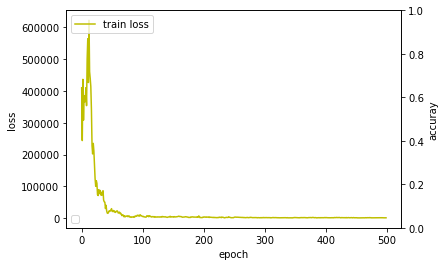

In [7]:
#train loss plt로 그려내기

%matplotlib inline
import matplotlib.pyplot as plt


print(custom_hist)
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(custom_hist.train_loss, 'y', label='train loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [8]:
#모델의 가중치 save
dqn_agent.save_model("model.h5")